# Visual Question Answering by Deep Learning

## Several Resources
- [article](http://iamaaditya.github.io/2016/04/visual_question_answering_demo_notebook) and [jupyter notebook](https://github.com/iamaaditya/VQA_Demo/blob/master/Visual_Question_Answering_Demo_in_python_notebook.ipynb) and [github](https://github.com/iamaaditya/VQA_Demo) from Aaditya Prakash
- [article](https://avisingh599.github.io/deeplearning/visual-qa/) and [github](https://github.com/avisingh599/visual-qa) from Avi Singh
- [VQA website](http://visualqa.org/) with dataset download

## Idea
- Use CNN to convert images into vectors (e.g., by VGG16)
- Use word embedding to convert words into vectors, and use LSTM to convert sentences into vectors (several layers of LSTM can capture higher order sequence dependencies)
- Merge image vectors and text vectors, and use a deep MLP to learn their correlations - So far the output is a fixed set of word labels (so still not really an open-question-answering system yet...)

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
from IPython import display

In [20]:
import keras

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 980M (CNMeM is disabled, cuDNN 5005)


In [21]:
import numpy as np

from keras import models, layers, optimizers, metrics
from keras.utils import visualize_util

from scipy.misc import imresize
from skimage.io import imread
from skimage.util import img_as_ubyte

## Image Vector Model
- VGG16 without the top 2 layers
- See [this notebook](keras-notes/IMAGE%20-%20CIFA%20with%20pretrained%20VGG.ipynb) for how to load pre-trained vgg
- previous versions of keras have problems with poping out layers, see [discussions](https://github.com/fchollet/keras/issues/2371#issuecomment-211734276) here

In [5]:
## code to pop last layer from model
## cited from https://github.com/fchollet/keras/issues/2640
def pop_layer(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')

    model.layers.pop()
    if not model.layers:
        model.outputs = []
        model.inbound_nodes = []
        model.outbound_nodes = []
    else:
        model.layers[-1].outbound_nodes = []
        model.outputs = [model.layers[-1].output]
    model.built = False

In [16]:
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D

def build_vgg16(weights_file = None):
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    
    if weights_file is not None:
        model.load_weights(weights_file)
    
    return model

image_model = build_vgg16("../data/vgg16_keras/vgg16_weights.h5")
print "original # of layers", len(image_model.layers), "output shape", image_model.output_shape
## pop out the last two layers
pop_layer(image_model)
pop_layer(image_model)
image_model.compile(loss = "mse", optimizer = "sgd")
print "after removing, # of layers", len(image_model.layers), "output_shape", image_model.output_shape

original # of layers 37 output shape (None, 1000)
after removing, # of layers 35 output_shape (None, 1000)


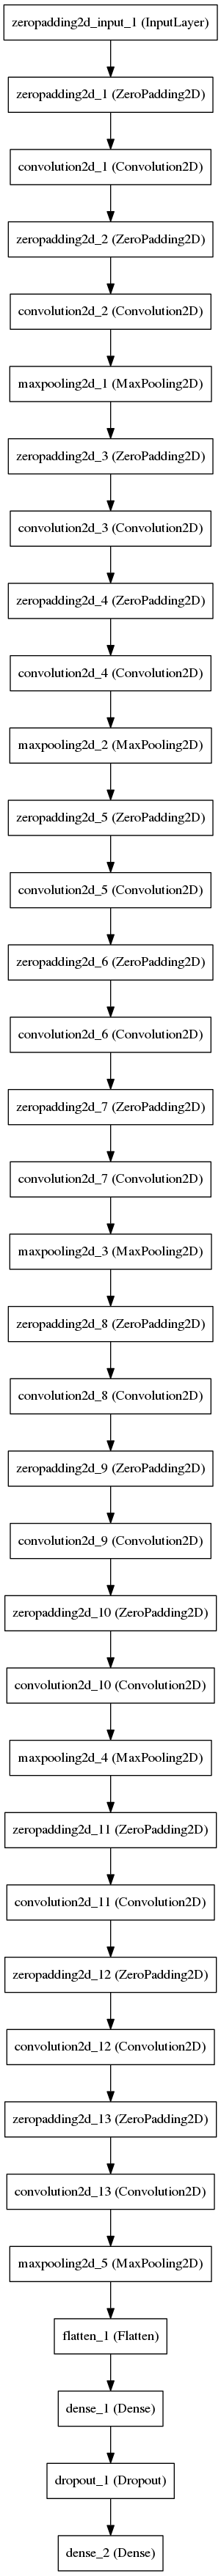

In [8]:
visualize_util.plot(image_model, to_file="../models/vgg16.png")
display.Image(filename = "../models/vgg16.png")

In [18]:
def img2vec(img):
    ## preprocessing
    img = imresize(img, (224, 224))
    img = img_as_ubyte(img).astype("float32")
    img[:,:,0] -= 103.939
    img[:,:,1] -= 116.779
    img[:,:,2] -= 123.68
    img = img.transpose((2, 0, 1))
    
    img_batch = np.expand_dims(img, axis = 0)
    
    vec = image_model.predict(img_batch)
    return vec

(1, 4096)

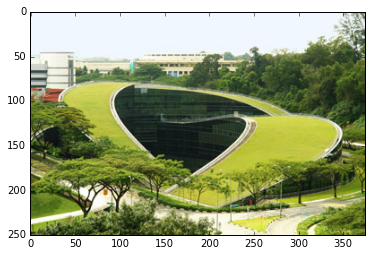

In [19]:
url = "http://www.ntu.edu.sg/AboutNTU/CorporateInfo/PublishingImages/Art-Design-and-Media-Building_web.jpg"
img = imread(url)
plt.imshow(img)
vec = img2vec(img)
vec.shape

## Word Vector Model
- use [spacy](https://spacy.io/) to load [glove](http://nlp.stanford.edu/projects/glove/) pretrained vectors
- install vector files in spacy
    - read [here](https://spacy.io/docs/tutorials/load-new-word-vectors) for how to load glove pretrained binary vectors via spacy
    - use [sputnik](https://github.com/spacy-io/sputnik), you need the latest spacy version for this to work, see [discussion](https://github.com/spacy-io/spaCy/issues/338) for spacy 0.101
    ```
    sputnik —name spacy install en
    sputnik --name spacy install en_glove_cc_300_1m_vectors
    ```
- alternatives include [skip-thoughts](https://github.com/ryankiros/skip-thoughts), [further reading](http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/)

In [12]:
from spacy.en import English
nlp = English()
## it is actually the same weights used by default
nlp.vocab.load_vectors("/home/dola/workspace/data/glove/glove.6B.300d.txt.bz2")

0

In [35]:
vking = nlp.vocab[u"king"].vector
vman = nlp.vocab[u"man"].vector
vwoman = nlp.vocab[u"woman"].vector

vqueen_estimate = vking - vmale + vfemale
vqueen = nlp.vocab[u"queen"].vector

from scipy.spatial.distance import cosine
print "cosine similarity", 1-cosine(vqueen_estimate, vqueen)

cosine similarity 0.613965627221


In [39]:
print "cosine similarity", 1-cosine(nlp.vocab[u"earth"].vector, nlp.vocab[u"moon"].vector)

cosine similarity 0.580242097378
